In [1]:
import os 
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import scgen
import seaborn as sns
from scipy import stats
import matplotlib
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
sc.set_figure_params(dpi_save=300)

/Users/Future/Library/Python/3.6/lib/python/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path_to_save = "../results/Figures/Supplemental Figure 9/"
os.makedirs(path_to_save, exist_ok=True)
sc.settings.figdir = path_to_save

In [3]:
train = sc.read("../data/train_species.h5ad")
train

AnnData object with n_obs × n_vars = 62114 × 6619 
    obs: 'condition', 'species', 'individual', 'batch', 'louvain', 'n_counts'
    var: 'gene_ids-0-0-0-0', 'gene_ids-1-0-0-0', 'gene_ids-2-0-0-0', 'gene_ids-0-1-0-0', 'gene_ids-1-1-0-0', 'gene_ids-2-1-0-0', 'gene_ids-0-0-1-0', 'gene_ids-1-0-1-0', 'gene_ids-2-0-1-0', 'gene_ids-0-1-1-0', 'gene_ids-1-1-1-0', 'gene_ids-2-1-1-0', 'gene_ids-3-1-1-0', 'gene_ids-0-0-0-1', 'gene_ids-1-0-0-1', 'gene_ids-2-0-0-1', 'gene_ids-0-1-0-1', 'gene_ids-1-1-0-1', 'gene_ids-2-1-0-1', 'gene_ids-0-0-1-1', 'gene_ids-1-0-1-1', 'gene_ids-2-0-1-1', 'gene_ids-0-1-1-1', 'gene_ids-1-1-1-1', 'gene_ids-2-1-1-1'
    uns: 'condition_colors', 'neighbors', 'species_colors'
    obsm: 'X_pca', 'X_umap'

In [4]:
train.obs.groupby(['species', 'condition']).size()

species  condition
mouse    LPS6         7428
         unst         7625
pig      LPS6         4806
         unst         8448
rabbit   LPS6         7107
         unst         8856
rat      LPS6         9423
         unst         8421
dtype: int64

In [5]:
network = scgen.VAEArith(x_dimension=train.shape[1], z_dimension=100, model_path="../models/scGen/species/rat/scgen")
network.restore_model()

INFO:tensorflow:Restoring parameters from ../models/scGen/species/rat/scgen


In [6]:
gene_list_dot = ['Ccl3',
 'Ccl4',
 'Nfkbia',
 'Sod2',
 'Isg15',
 'Il1a',
 'Ccl5',
 'Oasl1',
 'Tnfaip6',
 'Sdc4',
 'Anxa1',
 'Ehd1',
 'Nampt',
 'Ch25h',
 'Snx10',
 'Srgn',
 'Il18bp',
 'Mmp12',
 'Slc7a2',
 'Cd14',
 'Cd44',
 'Acsl1',
 'Cxcl5',
 'Ier3']

In [7]:
rabbit = train[train.obs["species"] == "rabbit"]
rabbit_cd = rabbit[rabbit.obs["condition"] == "unst"]
rabbit_stim = rabbit[rabbit.obs["condition"] == "LPS6"]
pig = train[train.obs["species"] == "pig"]
pig_cd = pig[pig.obs["condition"] == "unst"]
pig_stim = pig[pig.obs["condition"] == "LPS6"]
mouse = train[train.obs["species"] == "mouse"]
mouse_cd = mouse[mouse.obs["condition"] == "unst"]
mouse_stim = mouse[mouse.obs["condition"] == "LPS6"]
rat = train[train.obs["species"] == "rat"]
rat_cd = rat[rat.obs["condition"] == "unst"]
rat_stim = rat[rat.obs["condition"] == "LPS6"]

print(mouse_cd.shape, mouse_stim.shape)

(7625, 6619) (7428, 6619)


In [8]:
mouse_lps6_latent = network.to_latent(mouse_stim.X.A)
mouse_cd_latent = network.to_latent(mouse_cd.X.A)
rat_lps6_latent = network.to_latent(rat_stim.X.A)
rat_cd_latent = network.to_latent(rat_cd.X.A)
pig_lps6_latent = network.to_latent(pig_stim.X.A)
pig_cd_latent = network.to_latent(pig_cd.X.A)
rabbit_cd_latent = network.to_latent(rabbit_cd.X.A)
rabbit_lps6_latent = network.to_latent(rabbit_stim.X.A)

In [9]:
sc.tl.rank_genes_groups(rat, groupby="condition", method="wilcoxon", n_genes=100)
gene_list = rat.uns['rank_genes_groups']['names']["LPS6"].tolist()

In [17]:
def analyze_with_diff_delta(kind=1, figure="a"):
    min_size_lps6 = np.min([mouse_lps6_latent.shape[0], 
                            rat_lps6_latent.shape[0],
                            pig_lps6_latent.shape[0],
                            rabbit_lps6_latent.shape[0]])
    lps6_all = np.concatenate([mouse_lps6_latent, 
                               pig_lps6_latent,
                               rabbit_lps6_latent], axis=0)
    
    cd_all = np.concatenate([mouse_cd_latent, 
                             rat_cd_latent,
                             pig_cd_latent,
                             rabbit_cd_latent], axis=0)
    min_size = np.min([lps6_all.shape[0], cd_all.shape[0]])
    min_pop = np.min([mouse_lps6_latent.shape[0], mouse_cd_latent.shape[0]])
    idx_all = np.random.choice(np.arange(min_size), min_size, replace=False)
    idx = np.random.choice(np.arange(min_pop), min_pop, replace=False)
    delta_lps = np.average(mouse_lps6_latent[idx],axis=0) -  np.average(mouse_cd_latent[idx],axis=0)
    delta_species = np.average(rat_cd_latent[idx],axis=0) - np.average(mouse_cd_latent[idx],axis=0)
    delta_avg = np.average(lps6_all[idx_all], axis=0) - np.average(cd_all[idx_all], axis=0)
    shapes = [mouse_lps6_latent.shape[0], rat_cd_latent.shape[0]]
    arg_min = np.argmin(shapes)
    subsample_index =  np.random.choice(np.arange(shapes[arg_min]),shapes[arg_min],replace=False)
    if kind == 1:
        pred_rat_latent = mouse_cd_latent + delta_lps  + delta_species
        pred_rat = network.reconstruct(pred_rat_latent, use_data=True)
    elif kind == 2:
        pred_rat_latent = rat_cd_latent + delta_lps  
        pred_rat = network.reconstruct(pred_rat_latent, use_data=True)
    elif kind == 3:
        pred_rat_latent = mouse_lps6_latent + delta_species
        pred_rat = network.reconstruct(pred_rat_latent, use_data=True)
    elif kind == 4:
        pred_rat_latent = rat_cd_latent + delta_avg
        pred_rat = network.reconstruct(pred_rat_latent, use_data=True)
    
    all_adata = sc.AnnData(np.concatenate([rat_cd.X.A, rat_stim.X.A, pred_rat]))
    all_adata.obs["condition"] = ["ctrl"] * len(rat_cd) + ["real_stim"] * len(rat_stim) + ["pred_stim"] * len(pred_rat)
    all_adata.var_names = train.var_names
    
    conditions = {"pred_stim": "pred_stim", "real_stim": "real_stim"}
    print(all_adata.obs.groupby(['condition']).size())
    scgen.plotting.reg_mean_plot(all_adata, 
                                 labels={"x":"", "y":""},
                                 condition_key="condition",
                                 axis_keys={"x": conditions["pred_stim"], "y": conditions["real_stim"]},
                                 gene_list=gene_list[:5],
                                 top_100_genes=gene_list,
                                 path_to_save=os.path.join(path_to_save, f"SupplFig9{figure}_study_reg_mean.pdf"),
                                 legend=False,
                                 title="",
                                 fontsize=18,
                                 textsize=12,
                                 range=[0, 6, 1],
                                 x_coeff=0.45,
                                 show=True)
    
    all_stim = sc.AnnData(np.concatenate([rat_stim.X.A, pred_rat, rat_cd.X.A, 
                                          rabbit_cd.X.A, rabbit_stim.X.A, 
                                          pig_cd.X.A, pig_stim.X.A, 
                                          mouse_cd.X.A,mouse_stim.X.A]))
    all_stim.var_names = train.var_names
    all_stim.obs["condition"] = ["rat_LPS6"]*len(rat_stim) + ["rat_LPS6_pred"]*len(pred_rat)\
    +["rat_ctrl"]*len(rat_cd) + ["rabbit_ctrl"]*len(rabbit_cd)  + ["rabbit_LPS6"] *len(rabbit_stim)\
    + ["pig_ctrl"]*len(pig_cd) + ["pig_LPS6"]*len(pig_stim) + ["mouse_ctrl"]*len(mouse_cd)\
    + ["mouse_LPS6"]*len(mouse_stim)
    sc.set_figure_params(fontsize=14)
    print(all_stim.obs.groupby(['condition']).size())
    sc.pl.dotplot(all_stim, groupby="condition", var_names=gene_list_dot,
              save=f"_study_{kind}.pdf", use_raw=False)
    os.rename(src=os.path.join(path_to_save, f"dotplot_study_{kind}.pdf"), 
              dst=os.path.join(path_to_save, f"SupplFig9{figure}_dotplot_{kind}.pdf"))

condition
ctrl         8421
pred_stim    7625
real_stim    9423
dtype: int64
0.7267979577165883
0.9079077848969507


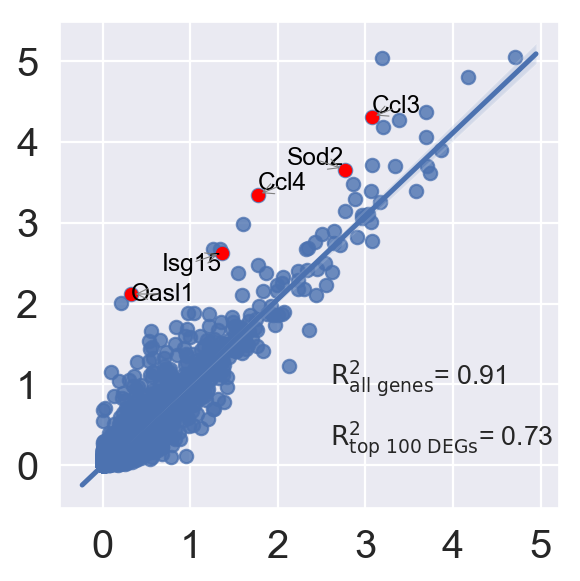

... storing 'condition' as categorical


condition
mouse_LPS6       7428
mouse_ctrl       7625
pig_LPS6         4806
pig_ctrl         8448
rabbit_LPS6      7107
rabbit_ctrl      8856
rat_LPS6         9423
rat_LPS6_pred    7625
rat_ctrl         8421
dtype: int64
saving figure to file ../results/Figures/Supplemental Figure 9/dotplot_study_1.pdf


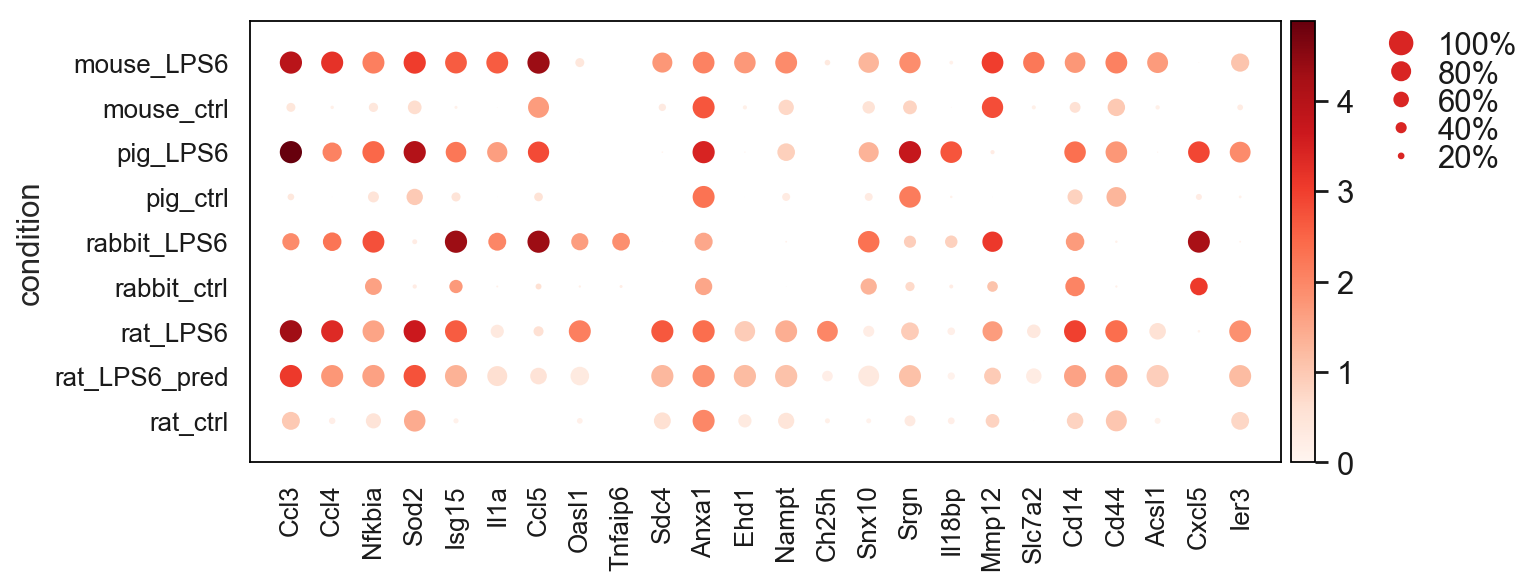

In [18]:
analyze_with_diff_delta(1, "a")

condition
ctrl         8421
pred_stim    8421
real_stim    9423
dtype: int64
0.761630733568836
0.9144575438192994


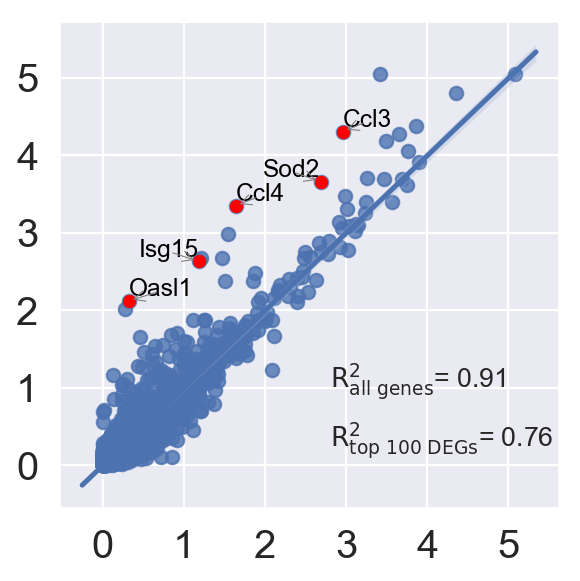

... storing 'condition' as categorical


condition
mouse_LPS6       7428
mouse_ctrl       7625
pig_LPS6         4806
pig_ctrl         8448
rabbit_LPS6      7107
rabbit_ctrl      8856
rat_LPS6         9423
rat_LPS6_pred    8421
rat_ctrl         8421
dtype: int64
saving figure to file ../results/Figures/Supplemental Figure 9/dotplot_study_2.pdf


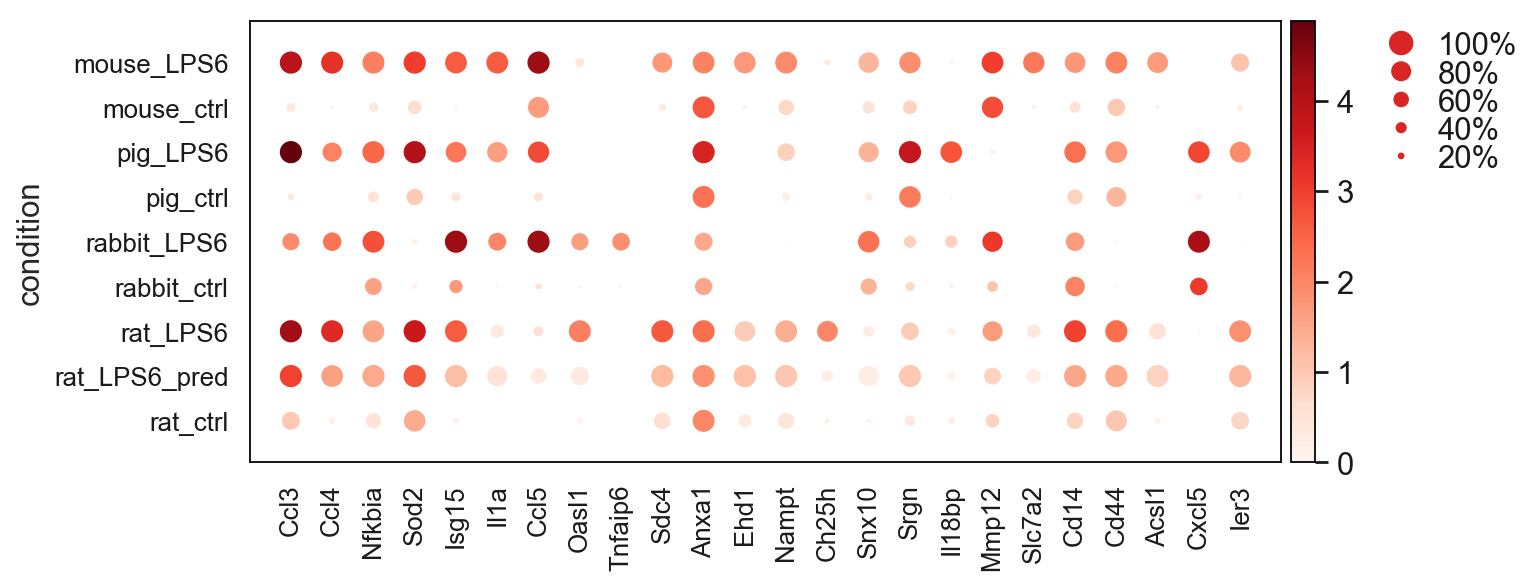

In [19]:
analyze_with_diff_delta(2, "b")

condition
ctrl         8421
pred_stim    7428
real_stim    9423
dtype: int64
0.7158162490860192
0.9051817163900575


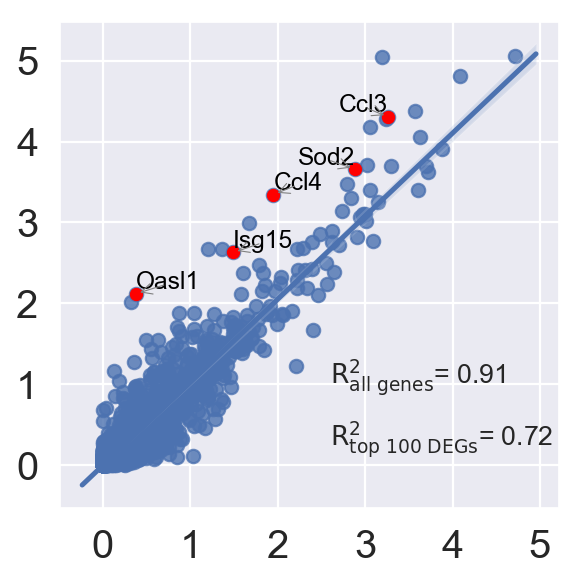

... storing 'condition' as categorical


condition
mouse_LPS6       7428
mouse_ctrl       7625
pig_LPS6         4806
pig_ctrl         8448
rabbit_LPS6      7107
rabbit_ctrl      8856
rat_LPS6         9423
rat_LPS6_pred    7428
rat_ctrl         8421
dtype: int64
saving figure to file ../results/Figures/Supplemental Figure 9/dotplot_study_3.pdf


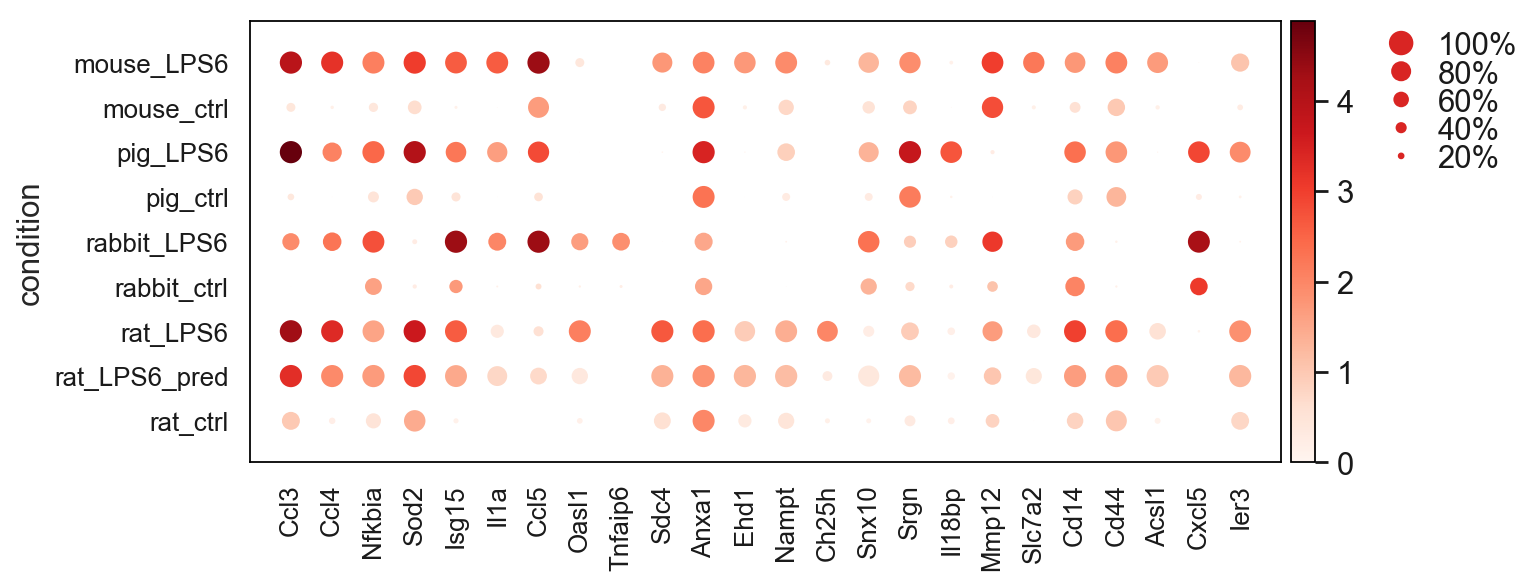

In [20]:
analyze_with_diff_delta(3, "c")

condition
ctrl         8421
pred_stim    8421
real_stim    9423
dtype: int64
0.6237106441134083
0.8882919978946578


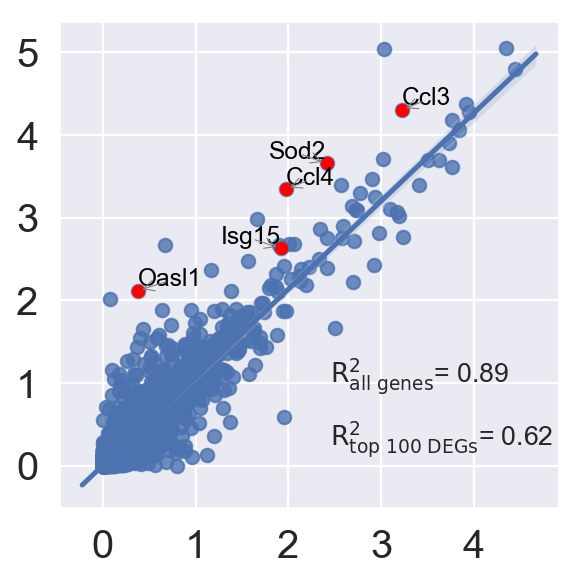

... storing 'condition' as categorical


condition
mouse_LPS6       7428
mouse_ctrl       7625
pig_LPS6         4806
pig_ctrl         8448
rabbit_LPS6      7107
rabbit_ctrl      8856
rat_LPS6         9423
rat_LPS6_pred    8421
rat_ctrl         8421
dtype: int64
saving figure to file ../results/Figures/Supplemental Figure 9/dotplot_study_4.pdf


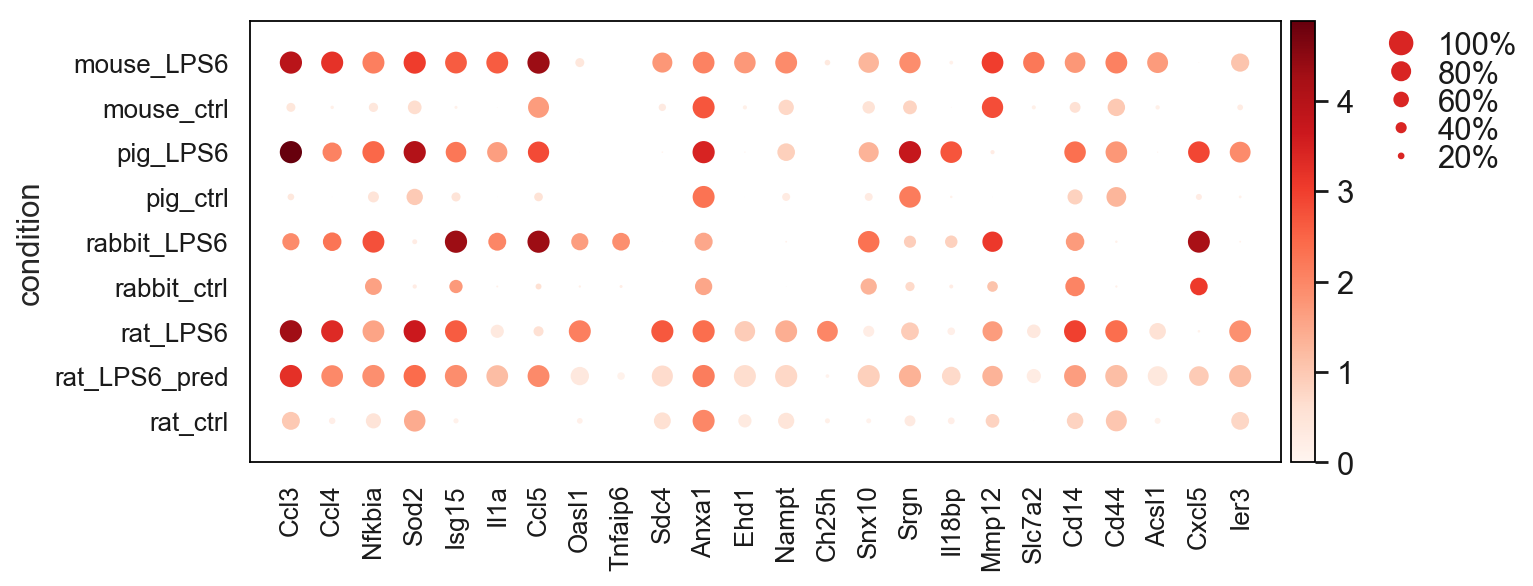

In [21]:
analyze_with_diff_delta(4, "d")